## Importing packages 


In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from category_encoders import BinaryEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2 #For feature selection
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim

## Preface

In this snippet of code im exploring the data in order to understand it better before encoding it. Im intetersted in finding out how many unique answers there are per question and in general how many responses there are per unique response.



In [42]:
# Load the clean dataset with explicit encoding
df = pd.read_csv('clean_kaggle_data_2022.csv', encoding='ISO-8859-1')
df_head = pd.read_csv('clean_kaggle_data_2022.csv', encoding='ISO-8859-1', nrows=1)

# Get the first row as column names
column_names=df_head.columns.tolist()

# Drop the first two rows (header and unit information)
df = df[2:]

# Set the column names
df.columns = column_names

# Iterate through each column starting from the second column (index 1)
response_tally = []

for column in df.columns[1:]:
    responses = df[column].value_counts().reset_index()
    responses.columns = ['Response', 'Count']
    responses['Column'] = column
    response_tally.append(responses)

# Concatenate the response tally dataframes
result_df = pd.concat(response_tally, ignore_index=True)

# Save the result to an Excel file
result_df.to_excel('numberOfResponsesPerClass.xlsx', index=False)



# Load the Excel file into a DataFrame
df = pd.read_excel('response_tally.xlsx')

# Initialize an empty dictionary to hold string tallies
column_tally = {}

# Loop through each row in the "Column" column
for item in df['Column']:
    if item in column_tally:
        column_tally[item] += 1                        
    else:
        column_tally[item] = 1

# Convert the column tally dictionary to a DataFrame
output_df = pd.DataFrame(list(column_tally.items()), columns=['Column', 'Tally'])

# Save the DataFrame to a new Excel file
output_df.to_excel('numberOfclassesPerQuestion.xlsx', index=False)


C:\Users\souren\AppData\Local\Temp\ipykernel_20320\1805201957.py:2: DtypeWarning: Columns (0,15,43,57,73,88,104,118,126,132,170,200,215,248,272,281,294) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('clean_kaggle_data_2022.csv', encoding='ISO-8859-1')


ModuleNotFoundError: No module named 'openpyxl'

## Question 1: Data Cleaning/Encoding

**Firstly**, Even though we now understand the general shape of the responses we need to look deeper. It is clear that the target variable Q29 has already be encoded, therefore the original can be removed from the data frame to prevent confusion. 

**Second**, the time it takes to complete the survery is not an indicator of our target variable, therefore it will also be removed. 

**Third**, it is simpler and less error prone to remove the first row of the data frame as it is a description for the column. An alternative approach is to use "skip row" arguement, however there is no need to to keep the row in the data frame. 

**<u>Encodings</u>**

**Questions 2, 11, 16,25,26,30,43** are ordinal in nature and therefore label encoding is used. The numbers assigned are arbitrarly, and we fill the missing values with mean, which does have potential to introduce bias into the model. 

**Question 9** is binary in nature and therefore the true and false will be converted to 0 and 1.

**Remaining Questions** the remaining questions/columns will one-hot encoded because by nature they almost are alrady, they are categorical. It will also convey to the model that they are indepewantt of one another, however it will increase the dimensioality of the dataset. 




In [10]:
import pandas as pd

# Function to load and process data
def load_and_process_data(filepath):
    # Load dataset
    dataset = pd.read_csv(filepath)
    
    # Drop specified columns and the first row
    columns_to_drop = ['Q5', 'Duration (in seconds)', 'Q29']
    dataset.drop(columns=columns_to_drop, inplace=True)
    dataset.drop(index=0, inplace=True)

    # Mapping for ordinal encoding
    ordinal_mappings = {
        'Q2': {'18-21':0, '22-24':1, '25-29':2, '30-34':3, '35-39':4, '40-44':5, '45-49':6, '50-54':7, '55-59':8, '60-64':9, '65-69':10, '70+':11},
        'Q11': {'I have never written code':0, '<1 years':1, '1-3 years':2, '3-5 years':3, '5-10 years':4, '10-20 years':5, '20+ years':6},
        'Q16': {'I do not use machine learning methods':0, 'Under 1 year':1, '1-2 years':2, '2-3 years':3, '3-4 years':4, '4-5 years':5, '5-10 years':6, '10-20 years':7},
        'Q25': {'0-49 employees':0, '50-249 employees':1, '250-999 employees':2, '1000-9,999 employees':3, '10,000 or more employees':4},
        'Q26': {'0':0, '1-2':1, '3-4':2, '5-9':3, '10-14':4, '15-19':5, '20+':6},
        'Q30': {'$0 (USD)':0, '$1-$99':1, '$100-$999':2, '$1000-$9,999':3, '$10000-$99999':4, '$100000 or more (USD)':5},
        'Q43': {'Never':0, 'Once':1, '2-5 times':2, '6-25 times':3, 'More than 25 times':4}
    }

    # Apply ordinal mappings and fill missing values
    for col, mapping in ordinal_mappings.items():
        dataset[col] = dataset[col].map(mapping)
        dataset[col].fillna(dataset[col].mean(), inplace=True)

    # Binary encoding for Q9
    dataset['Q9'] = dataset['Q9'].replace({'No': 0, 'Yes': 1})
    dataset['Q9'].fillna(dataset['Q9'].mean(), inplace=True)

    # Preserve ordinal and target columns before one-hot encoding
    preserved_columns = dataset[['Q2', 'Q11', 'Q16', 'Q25', 'Q26', 'Q30', 'Q43', 'Q9']]
    
    # Drop preserved columns from the dataset to avoid duplicating them during concatenation
    dataset = dataset.drop(columns=preserved_columns.columns)
    
    # One-hot encoding for categorical features
    categorical_features = dataset.select_dtypes(include=['object']).columns
    dataset = pd.get_dummies(dataset, columns=categorical_features)
    
    # Merge the preserved and one-hot encoded data
    processed_data = pd.concat([dataset, preserved_columns], axis=1)

    return processed_data

# Define the file path
data_file = 'clean_kaggle_data_2022.csv'

# Process the data
cleaned_data = load_and_process_data(data_file)

# Display the first few rows of the processed dataframe
print(cleaned_data.head())


C:\Users\souren\AppData\Local\Temp\ipykernel_19512\2853924899.py:6: DtypeWarning: Columns (0,15,43,57,73,88,104,118,126,132,170,200,215,248,272,281,294) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(filepath)


   Q29_Encoded  Q3_Man  Q3_Nonbinary  Q3_Prefer not to say  \
1          2.0    True         False                 False   
2         10.0    True         False                 False   
3         10.0    True         False                 False   
4         13.0    True         False                 False   
5         13.0    True         False                 False   

   Q3_Prefer to self-describe  Q3_Woman  Q4_Algeria  Q4_Argentina  \
1                       False     False       False         False   
2                       False     False       False         False   
3                       False     False       False         False   
4                       False     False       False         False   
5                       False     False       False         False   

   Q4_Australia  Q4_Bangladesh  ...  Q29_buckets_90,000-99,999  \
1         False          False  ...                      False   
2         False          False  ...                      False   
3          Tru

## Question 2: Exploratory data analysis and feature selection:

Similar to the preface the goal of this section is to under the feautures better, since they are now encoded it is good to again viszualize the inputs into the model. After plotting the encoded target variable it is evident that it is left-skewed, and we should expect to see similar behaviour from the model. 



Feature selection is crucial especially when computing resouces are limited because it allows you to only take into account the features that have an impact on the target variable. Our approach will use the Chi-squared scores, and this method returns a p-value and chi-scored value. This method is an idicator of how heavily each feature affects the target variable. It is a tried and true method for categorical data however does not account for inter-feature relationships;yet it is very good for capturing non-linear relationships. 


The total number of features we have is 396, and not all of these features heavily affect the target variable as we can see from the output of our chi-squared function. However due to my personal setup and avialbility of a GPU I will opt to use all the features, in an attemept to capture the relatiobhips between the features as well. 

We then use the Kbest method to select the best feautures, which would be extremly useful if we were not using all of the features. We also create a new dataframe called df_model which we will derive our testing and training datasets from. 

<Axes: xlabel='Q29_Encoded', ylabel='count'>

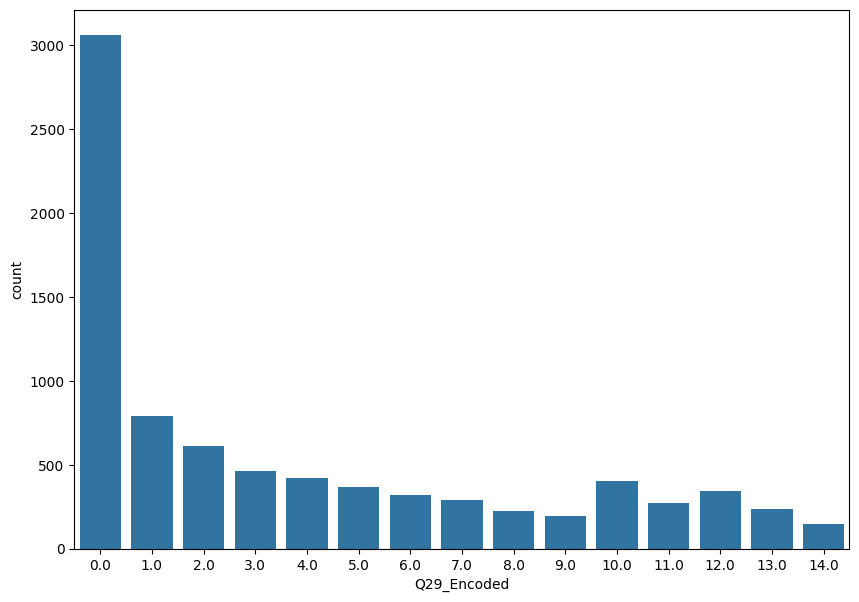

In [11]:
#plotting to see the distribution of the target variable
plt.figure(figsize=(10,7))
sns.countplot(x='Q29_Encoded', data=cleaned_data)

In [12]:
# Create X (features) and y (target) dataframes for feature selection
X = cleaned_data.drop(columns=['Q29_Encoded'], axis=1)
y = cleaned_data['Q29_Encoded']

# Calculate chi-squared scores of all features
chi_scores = chi2(X, y)

# chi_scores will return two arrays, one for scores and one for p-values
chi2_scores = chi_scores[0]
p_values = chi_scores[1]

# Create a DataFrame to view the scores and p-values for each feature
chi2_results = pd.DataFrame({'feature': X.columns, 'chi2_score': chi2_scores, 'p_value': p_values})

# Display the results sorted by chi2_score in descending order
chi2_results_sorted = chi2_results.sort_values(by='chi2_score', ascending=False)
print(chi2_results_sorted)

                                            feature   chi2_score   p_value
402                            Q29_buckets_>300,000  7989.000000  0.000000
401                       Q29_buckets_90,000-99,999  7939.000000  0.000000
400                       Q29_buckets_80,000-89,999  7914.000000  0.000000
394                     Q29_buckets_200,000-299,999  7903.000000  0.000000
391                     Q29_buckets_125,000-149,999  7867.000000  0.000000
..                                              ...          ...       ...
17                                       Q4_Ecuador     7.280090  0.923374
321                               Q37_8_ Rapidminer     7.252171  0.924553
204  Q22_Other storage services (i.e. google drive)     6.414428  0.954941
255                           Q31_8_ Alibaba Cloud      4.837941  0.987943
262                              Q32_ Huawei Cloud      1.660562  0.999974

[411 rows x 3 columns]


<Axes: title={'center': 'Top 20 Highest Chi-squared Features'}, ylabel='Chi-squared'>

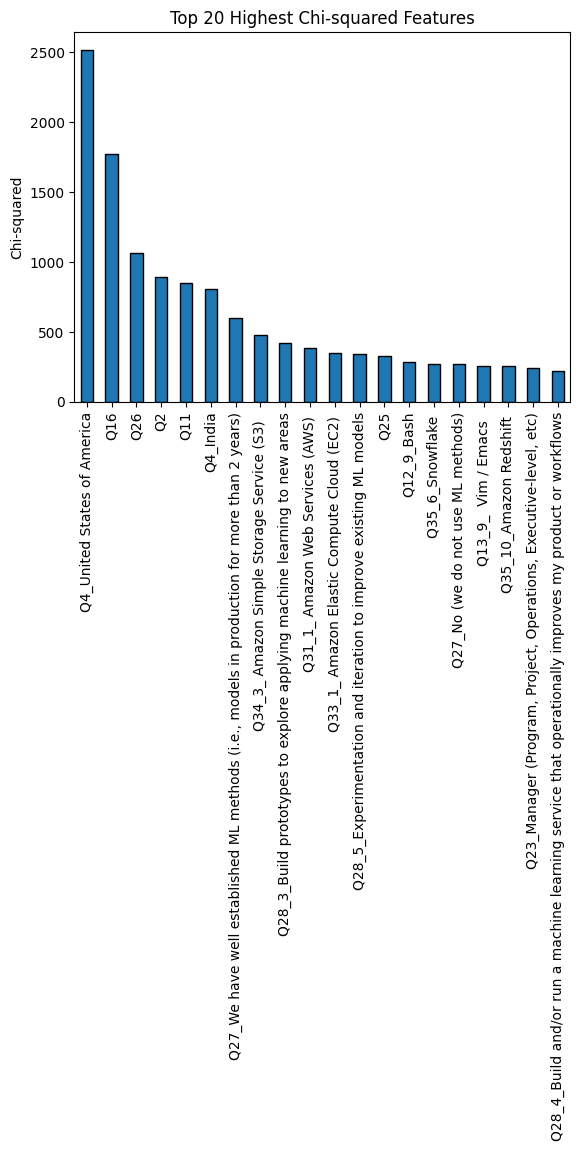

In [20]:
#using all features.
k = 396
#Visualzing the most important features 
chi_values = pd.Series(chi_scores[0], index=X.columns)
chi_values.sort_values(ascending=False, inplace=True)
plt.title("Top 20 Highest Chi-squared Features")
plt.ylabel("Chi-squared")
chi_values.head(20).plot.bar(edgecolor='black')



In [14]:
# number of features
k = 'all'
# Set features to be selected through K best, even though redundant since we are using 
# all features
selector = SelectKBest(score_func=chi2, k=k)
X_new = selector.fit_transform(X, y)  # X and y are from the previous step
selected_feature_indices = selector.get_support(indices=True)
selected_features = X.columns[selected_feature_indices]
# Shows selected features in alphabetical order
print(selected_features)
# Filter encoded dataframe to only have selected features
df_model = cleaned_data[selected_features]
df_model = pd.concat([df_model, cleaned_data[['Q29_Encoded']]], axis=1)

# Display the first few rows of the filtered dataframe
print(df_model.head())



# Create X and y dataframes for splitting and training
# 'Q29_buckets' is removed since it's not in the df_selected DataFrame
X = cleaned_data.drop(columns=['Q29_Encoded'])  # Drop the target variable to isolate features
y = cleaned_data['Q29_Encoded']  # Isolate the target variable

# Split X and y with an 80:20 training-to-testing split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Since you want to use all features, the use of SelectKBest is not necessary.
# However, if you still want to fit SelectKBest to possibly select features later, you can do so.
# Here's how you would fit SelectKBest to the training data:
selector = SelectKBest(score_func=chi2, k='all')  # 'all' means that no feature selection is done
selector.fit(X_train, y_train)  # Fit to the training set only to avoid data leakage

# Transform both training and testing sets
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# If you want to see which features are selected (even though we're using all), you can do this:
selected_features = X.columns[selector.get_support(indices=True)]
print("Selected features:", selected_features)

# Convert the selected training and testing sets back to DataFrame for convenience
X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features)
X_test_selected = pd.DataFrame(X_test_selected, columns=selected_features)

# Display the first few rows of the filtered DataFrame and the shapes of the train and test sets
print(X_train_selected.head())
print("X_train shape:", X_train_selected.shape)
print("X_test shape:", X_test_selected.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)



Index(['Q3_Man', 'Q3_Nonbinary', 'Q3_Prefer not to say',
       'Q3_Prefer to self-describe', 'Q3_Woman', 'Q4_Algeria', 'Q4_Argentina',
       'Q4_Australia', 'Q4_Bangladesh', 'Q4_Belgium',
       ...
       'Q29_buckets_90,000-99,999', 'Q29_buckets_>300,000', 'Q2', 'Q11', 'Q16',
       'Q25', 'Q26', 'Q30', 'Q43', 'Q9'],
      dtype='object', length=411)
   Q3_Man  Q3_Nonbinary  Q3_Prefer not to say  Q3_Prefer to self-describe  \
1    True         False                 False                       False   
2    True         False                 False                       False   
3    True         False                 False                       False   
4    True         False                 False                       False   
5    True         False                 False                       False   

   Q3_Woman  Q4_Algeria  Q4_Argentina  Q4_Australia  Q4_Bangladesh  \
1     False       False         False         False          False   
2     False       False         False   

## Question 3: Model Implementation

In preperation for setting up our model, we will re-run data encoding and cleaning steps in a function like manner to make sure that any unwanted manipulations to the dataset and the encodings are reset before inataiting the model. By setting up the cleaning, encoding, training and testing datasets before the model it is also easier to deal with possible type error and other data mismatch type problems while both creating and fine tuning the model.

The Training and Testing datasets will be 80% and 20% respectively, and we will use pytorch as our model building blocks. Set up a logisticregression model with n_classes which will make it a multiclass logisticregression model. We will use standard gradient descent SGD, and this gives us two hyper-parameters that we can tune, one is the learning rate "lr" and one is the weight decay parameter. The learning rate parameter dictate how much the model moves along the 'curve' in each step, so a higher learning rate would mean more corrections in terms of the negative gradiatn in each itteration. the model doesn't have the "c" parameter but it the weight decay parameter is really where the "c" parameter comes from, since c is 1/weight_decay. The weight decay is a partial solution to over fitting; in simple terms it prevents the model from creating a complex descion boundyr that zig zags to classify every point correctly, and it is often assocaited with L2 regularizxation method.  

In [3]:
# Load the dataset
df = pd.read_csv("clean_kaggle_data_2022.csv")

# Handling missing values by filling 'null' with 'unknown'

df = df.drop(["Q5"], axis=1)
df = df.drop(["Duration (in seconds)", "Q29"], axis=1)
df = df.drop(0)


# Set encoding labels manually for ordinal columns
Q2_encode = {
    "18-21": 0,
    "22-24": 1,
    "25-29": 2,
    "30-34": 3,
    "35-39": 4,
    "40-44": 5,
    "45-49": 6,
    "50-54": 7,
    "55-59": 8,
    "60-64": 9,
    "65-69:": 10,
    "70+": 11,
}
Q11_encode = {
    "I have never written code": 0,
    "<1 years": 1,
    "1-3 years": 2,
    "3-5 years": 3,
    "5-10 years": 4,
    "10-20 years": 5,
    "20+ years": 6,
}
Q16_encode = {
    "I do not use machine learning methods": 0,
    "Under 1 year": 1,
    "1-2 years": 2,
    "2-3 years": 3,
    "3-4 years": 4,
    "4-5 years": 5,
    "5-10 years": 6,
    "10-20 years": 7,
}
Q25_encode = {
    "0-49 employees": 0,
    "50-249 employees": 1,
    "250-999 employees": 2,
    "1000-9,999 employees": 3,
    "10,000 or more employees": 4,
}
Q26_encode = {
    "0": 0,
    "2-Jan": 1,
    "4-Mar": 2,
    "9-May": 3,
    "14-Oct": 4,
    "15-19": 5,
    "20+": 6,
}
Q30_encode = {
    "$0 ($USD)": 0,
    "$1-$99": 1,
    "$100-$999": 2,
    "$1000-$9,999": 3,
    "$0 ($USD)": 4,
    "$10,000-$99,999": 5,
    "$100,000 or more ($USD)": 6,
}
Q43_encode = {
    "Never": 0,
    "Once": 1,
    "2-5 times": 2,
    "6-25 times": 3,
    "More than 25 times": 4,
}

# Encode ordinal columns of dataset
df["Q2"] = df["Q2"].map(Q2_encode)
df["Q11"] = df["Q11"].map(Q11_encode)
df["Q16"] = df["Q16"].map(Q16_encode)
df["Q25"] = df["Q25"].map(Q25_encode)
df["Q26"] = df["Q26"].map(Q26_encode)
df["Q30"] = df["Q30"].map(Q30_encode)
df["Q43"] = df["Q43"].map(Q43_encode)

# Fill in missing data in ordinal columns with its mean
col_ordinal = ["Q2", "Q11", "Q16", "Q25", "Q26", "Q30", "Q43"]
for col in col_ordinal:
    df[col].fillna(df[col].mean(), inplace=True)

# Encode Q9 column from Y/N to 0 and 1 and fill null with mean
df["Q9"] = df["Q9"].replace({"No": 0, "Yes": 1})
df["Q9"].fillna(df["Q9"].mean(), inplace=True)

# Temporarily remove ordinal and target columns
removed_col = df[
    ["Q2", "Q11", "Q16", "Q25", "Q26", "Q30", "Q43", "Q9", "Q29_Encoded", "Q29_buckets"]
]
df = df.drop(
    columns=[
        "Q2",
        "Q11",
        "Q16",
        "Q25",
        "Q26",
        "Q30",
        "Q43",
        "Q9",
        "Q29_Encoded",
        "Q29_buckets",
    ]
)

# Do one-hot encoding on rest of dataframe
df_encoded = pd.get_dummies(df)

# Reintroduce removed columns back into the dataframe
df_encoded = pd.concat([df_encoded, removed_col], axis=1)
df_encoded.head()

# Create X (features) and y (target variables) dataframes for feature selection
X = df_encoded.drop(columns=["Q29_Encoded", "Q29_buckets"], axis=1)
y = df_encoded["Q29_Encoded"]
k=396
# Calculate chi squared scores of all features
chi_scores = chi2(X, y)
chi_scores
# Set features to be selected through K best
selector = SelectKBest(score_func=chi2, k=k)
X_new = selector.fit_transform(X, y)
selected_feature_indices = selector.get_support(indices=True)
selected_features = X.columns[selected_feature_indices]
selected_features  # shows selected features in alphabetical order
# Filter encoded dataframe to only have selected features
df_selected = df_encoded[selected_features]
df_selected = pd.concat(
    [df_encoded[selected_features], df_encoded[["Q29_Encoded", "Q29_buckets"]]], axis=1
)
df_selected.head()

# Create X and y dataframes for splitting and training
X = df_selected.drop(columns=["Q29_Encoded", "Q29_buckets"], axis=1)
y = df_selected["Q29_Encoded"]

# Split X and y with an 80:20 training-to-testing split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


C:\Users\souren\AppData\Local\Temp\ipykernel_29364\998543102.py:2: DtypeWarning: Columns (0,15,43,57,73,88,104,118,126,132,170,200,215,248,272,281,294) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("clean_kaggle_data_2022.csv")


X_train shape: (6508, 396)
X_test shape: (1628, 396)
y_train shape: (6508,)
y_test shape: (1628,)


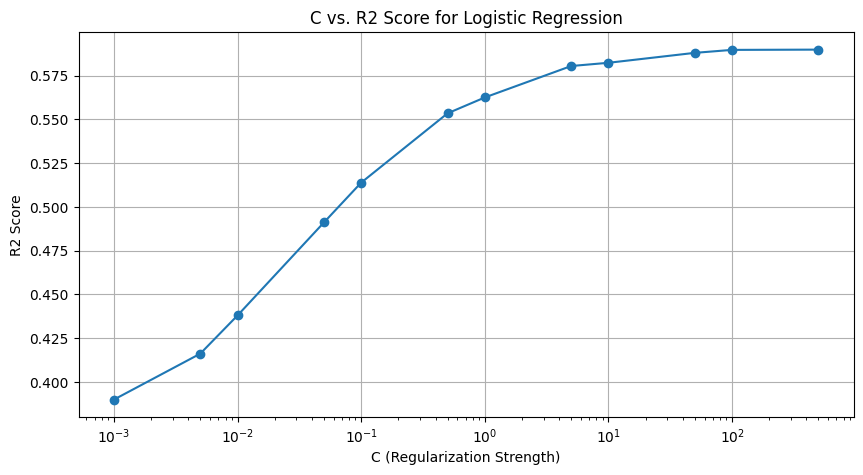

In [89]:
C = [0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100,500]
score = []

for C_val in C:
    model = LogisticRegression(C=C_val, solver='lbfgs',multi_class='multinomial',max_iter=10000)
    model.fit(X_train, y_train)
    score_val = model.score(X_train, y_train) #R2 score
    score.append(score_val)

plt.figure(figsize=(10, 5))
plt.semilogx(C, score, marker='o')
plt.title("C vs. R2 Score for Logistic Regression")
plt.xlabel("C (Regularization Strength)")
plt.ylabel("R2 Score")
plt.grid(True)
plt.show()

In [94]:
c_max = C[score.index(max(score))]
print(f'Highest R2: {max(score)}\nC value: {c_max}')
print(f'Therefore we can expect a weight decay value of around {1/c_max}')

#therfore we can expect a weight decay value of around 0.002

Highest R2: 0.5898893669330055
C value: 500
Therefore we can expect a weight decay value of around 0.002


In [24]:

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)

# Define the logistic regression model
class LogisticRegressionModel(nn.Module):
    def __init__(self, n_features, n_classes):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(n_features, n_classes)

    def forward(self, x):
        return self.linear(x)

# Define hyperparameters for grid search
weight_decays = [0.0001, 0.001, 0.01, 0.1, 1]
n_epochs = 50
batch_size = 64

# Set up K-Fold cross-validation
k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=True)

# Prepare to collect the fold results
grid_search_results = {}

# Start the cross-validation and grid search
for fold, (train_ids, val_ids) in enumerate(kfold.split(X_train_tensor)):
    print(f'Starting fold {fold+1}')

    # Split the data for this fold
    X_train_fold = X_train_tensor[train_ids]
    y_train_fold = y_train_tensor[train_ids]
    X_val_fold = X_train_tensor[val_ids]
    y_val_fold = y_train_tensor[val_ids]
    
    # Create DataLoaders for the current fold
    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    val_dataset = TensorDataset(X_val_fold, y_val_fold)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    for weight_decay in weight_decays:
        # Initialize the model for the current fold and weight decay
        model = LogisticRegressionModel(X_train_fold.shape[1], torch.max(y_train_tensor).item() + 1).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=weight_decay)
        criterion = nn.CrossEntropyLoss()

        # Train the model
        for epoch in range(n_epochs):
            model.train()
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                loss.backward()
                optimizer.step()

        # Evaluate the model on the validation set
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                _, predicted = torch.max(y_pred.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()
        
        # Calculate validation accuracy
        accuracy = correct / total
        print(f'Fold {fold+1}, Weight Decay {weight_decay}, Validation Accuracy: {accuracy}')

        # Update grid search results
        grid_search_results[(fold+1, weight_decay)] = accuracy

# Find the best weight decay value based on validation accuracy
best_weight_decay = max(grid_search_results, key=grid_search_results.get)[1]
print(f'Best weight decay: {best_weight_decay}')

# Calculate the average accuracy over all folds for the best weight decay
avg_accuracy = np.mean([val for key, val in grid_search_results.items() if key[1] == best_weight_decay])
print(f'Average validation accuracy for the best weight decay {best_weight_decay}: {avg_accuracy}')


Using GPU: NVIDIA GeForce RTX 3060
Starting fold 1
Fold 1, Weight Decay 0.0001, Validation Accuracy: 0.3425499231950845
Fold 1, Weight Decay 0.001, Validation Accuracy: 0.3456221198156682
Fold 1, Weight Decay 0.01, Validation Accuracy: 0.3548387096774194
Fold 1, Weight Decay 0.1, Validation Accuracy: 0.3640552995391705
Fold 1, Weight Decay 1, Validation Accuracy: 0.35023041474654376
Starting fold 2
Fold 2, Weight Decay 0.0001, Validation Accuracy: 0.3671274961597542
Fold 2, Weight Decay 0.001, Validation Accuracy: 0.3778801843317972
Fold 2, Weight Decay 0.01, Validation Accuracy: 0.3794162826420891
Fold 2, Weight Decay 0.1, Validation Accuracy: 0.3824884792626728
Fold 2, Weight Decay 1, Validation Accuracy: 0.37327188940092165
Starting fold 3
Fold 3, Weight Decay 0.0001, Validation Accuracy: 0.4162826420890937
Fold 3, Weight Decay 0.001, Validation Accuracy: 0.41935483870967744
Fold 3, Weight Decay 0.01, Validation Accuracy: 0.42242703533026116
Fold 3, Weight Decay 0.1, Validation Accu

Epoch 1/50 : Training Loss: 0.4225 - Training Accuracy: 0.0751 - Validation Loss: 0.4225 - Validation Accuracy: 0.0751
Epoch 2/50 : Training Loss: 0.4095 - Training Accuracy: 0.0776 - Validation Loss: 0.4095 - Validation Accuracy: 0.0776
Epoch 3/50 : Training Loss: 0.4073 - Training Accuracy: 0.0776 - Validation Loss: 0.4073 - Validation Accuracy: 0.0776
Epoch 4/50 : Training Loss: 0.4093 - Training Accuracy: 0.0773 - Validation Loss: 0.4093 - Validation Accuracy: 0.0773
Epoch 5/50 : Training Loss: 0.4137 - Training Accuracy: 0.0768 - Validation Loss: 0.4137 - Validation Accuracy: 0.0768
Epoch 6/50 : Training Loss: 0.4165 - Training Accuracy: 0.0774 - Validation Loss: 0.4165 - Validation Accuracy: 0.0774
Epoch 7/50 : Training Loss: 0.4192 - Training Accuracy: 0.0758 - Validation Loss: 0.4192 - Validation Accuracy: 0.0758
Epoch 8/50 : Training Loss: 0.4220 - Training Accuracy: 0.0767 - Validation Loss: 0.4220 - Validation Accuracy: 0.0767
Epoch 9/50 : Training Loss: 0.4273 - Training Ac

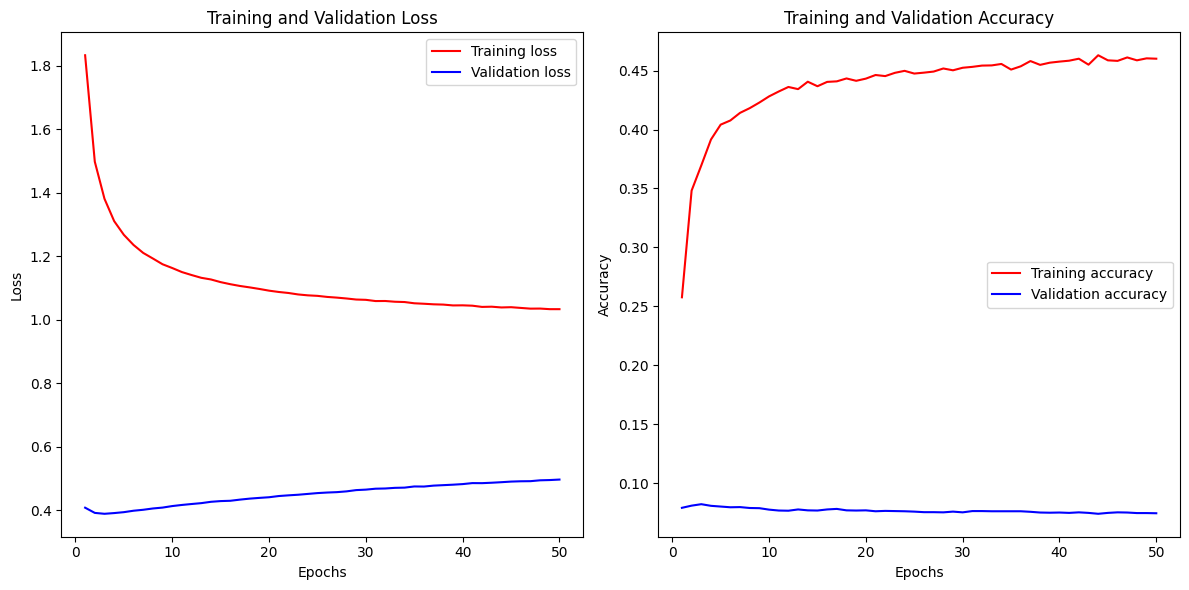

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Assuming X_train_scaled and y_train are numpy arrays containing your training data and labels
# Assuming X_train_scaled is a NumPy array and y_train is a pandas Series
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)  # Convert the pandas Series to NumPy array before converting to tensor


# Define the logistic regression model
class LogisticRegressionModel(nn.Module):
    def __init__(self, n_input_features, n_output_classes):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(n_input_features, n_output_classes)

    def forward(self, x):
        return self.linear(x)  # No softmax needed since it's included in nn.CrossEntropyLoss

# Initialize the model, loss criterion, and optimizer
device = "cpu"
n_input_features = X_train_tensor.shape[1]
n_output_classes = len(torch.unique(y_train_tensor))
model = LogisticRegressionModel(n_input_features, n_output_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Function to calculate the accuracy
def calculate_accuracy(y_pred, y_true):
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_true).sum().item()
    accuracy = correct / y_true.size(0)
    return accuracy

# Function to plot the learning curve
def plot_learning_curve(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'r', label='Training loss')
    plt.plot(epochs, val_losses, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'r', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Training and validation
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, n_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(outputs.max(1)[1] == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

        model.eval()
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(outputs.max(1)[1] == labels.data)

        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)

        val_losses.append(epoch_loss)
        val_accuracies.append(epoch_acc.item())

        print(f'Epoch {epoch+1}/{n_epochs} : Training Loss: {epoch_loss:.4f} - Training Accuracy: {epoch_acc:.4f} - Validation Loss: {epoch_loss:.4f} - Validation Accuracy: {epoch_acc:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies

# Set up K-Fold cross-validation
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)

# Placeholder for fold results
results = {}

# Loop through folds
for fold, (train_ids, val_ids) in enumerate(kfold.split(X_train_tensor)):

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
    
    # Define data loaders for training and validation data in this fold
    train_loader = torch.utils.data.DataLoader(
                      TensorDataset(X_train_tensor, y_train_tensor), 
                      batch_size=10, sampler=train_subsampler)
    val_loader = torch.utils.data.DataLoader(
                      TensorDataset(X_train_tensor, y_train_tensor),
                      batch_size=10, sampler=val_subsampler)

    # Init the neural network
    network = LogisticRegressionModel(n_input_features, n_output_classes).to(device)
    optimizer = optim.SGD(network.parameters(), lr=0.01)

    # Train the model for this fold
    train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate(network, train_loader, val_loader, criterion, optimizer, n_epochs=50)

    # Save the model that trained this fold
    torch.save(network.state_dict(), f'model_fold_{fold}.pth')
    
    # Save fold results
    results[fold] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }
    
    print(f'Fold {fold}: Accuracy {val_accuracies[-1]}')

# Plot the learning curve using the results of the last fold
plot_learning_curve(results[fold]['train_losses'], results[fold]['val_losses'], results[fold]['train_accuracies'], results[fold]['val_accuracies'])


## Question 4: Model Tuning 

In the previous step we discovered through grid-search that the best weight decay value is 0.1, now we can similarly experiment with learning rate, and # of epochs. the number of epochs usually has a asymptic behaviour and after a number ofe pcohs the model improvements are minimal. In the previous section the same grid search was applied to the learning rate and the learning rate of 0.01 was determined to be the best. Here we have now narrowed down two out of three hyperparameters and we will increase the number of epochs to observe any changes. 

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim

# Check if GPU is available and use CPU otherwise
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load and scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)

#Define the logistic regression model
class LogisticRegressionModel(nn.Module):
    def __init__(self, n_features, n_classes):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(n_features, n_classes)

    def forward(self, x):
        return self.linear(x)

# class LogisticRegressionModel(nn.Module):
#     def __init__(self, n_features, n_hidden1, n_hidden2, n_classes):
#         super(LogisticRegressionModel, self).__init__()
#         # First hidden layer
#         self.hidden1 = nn.Linear(n_features, n_hidden1)
#         # Second hidden layer
#         self.hidden2 = nn.Linear(n_hidden1, n_hidden2)
#         # Output layer
#         self.output = nn.Linear(n_hidden2, n_classes)
#         # Activation function
#         self.relu = nn.ReLU()
        
#     def forward(self, x):
#         x = self.relu(self.hidden1(x))  # Activation function for first hidden layer
#         x = self.relu(self.hidden2(x))  # Activation function for second hidden layer
#         x = self.output(x)  # No activation function here since nn.CrossEntropyLoss applies it
#         return x

# # Hyperparameters for the hidden layers
# n_hidden1 = 128
# n_hidden2 = 64


# Initialize the model
n_features = X_train_tensor.shape[1]
n_classes = len(torch.unique(y_train_tensor))
model = LogisticRegressionModel(n_features, n_classes).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters(), lr=0.05, weight_decay=0.1)

# Set up K-Fold cross-validation
k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=True)

# Train the model and evaluate
fold_accuracies = []

for fold, (train_ids, val_ids) in enumerate(kfold.split(X_train_tensor)):
    print(f'Starting fold {fold+1}/{k_folds}')

    # Split the data for this fold
    X_train_fold = X_train_tensor[train_ids]
    y_train_fold = y_train_tensor[train_ids]
    X_val_fold = X_train_tensor[val_ids]
    y_val_fold = y_train_tensor[val_ids]

    # Create DataLoaders for the current fold
    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    val_dataset = TensorDataset(X_val_fold, y_val_fold)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64)

    # Reset model and optimizer
    model = LogisticRegressionModel(n_features, n_classes).to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=0.01, weight_decay=0.1)

    # Train the model
    for epoch in range(200):  # Set number of epochs
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

    # Evaluate the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            _, predicted = torch.max(y_pred, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    # Calculate validation accuracy
    accuracy = correct / total
    print(f'Fold {fold+1}, Validation Accuracy: {accuracy}')
    fold_accuracies.append(accuracy)

# Calculate the average accuracy over all folds
avg_accuracy = np.mean(fold_accuracies)
print(f'Average validation accuracy: {avg_accuracy}')
# Saving the entire model
torch.save(model, 'finalModel.pth')


Using device: cuda
Starting fold 1/10


KeyboardInterrupt: 

In [24]:
# Assuming your validation DataLoader is named 'val_loader'
model.eval()  # Set the model to evaluation mode
y_true = []
y_pred = []
device="cuda"
model.to(device)  # Move the model to the device (CPU or GPU) that you specified earlier
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        # Move data back to CPU for evaluation metrics
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute the confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Compute the F1 score
f1 = f1_score(y_true, y_pred, average='weighted')  # Use 'macro' for unweighted average

print(f'F1 Score: {f1}')

# Display the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
print(classification_report(y_true, y_pred))


RuntimeError: Expected one of cpu, cuda, ipu, xpu, mkldnn, opengl, opencl, ideep, hip, ve, fpga, ort, xla, lazy, vulkan, mps, meta, hpu, mtia, privateuseone device type at start of device string: gpu

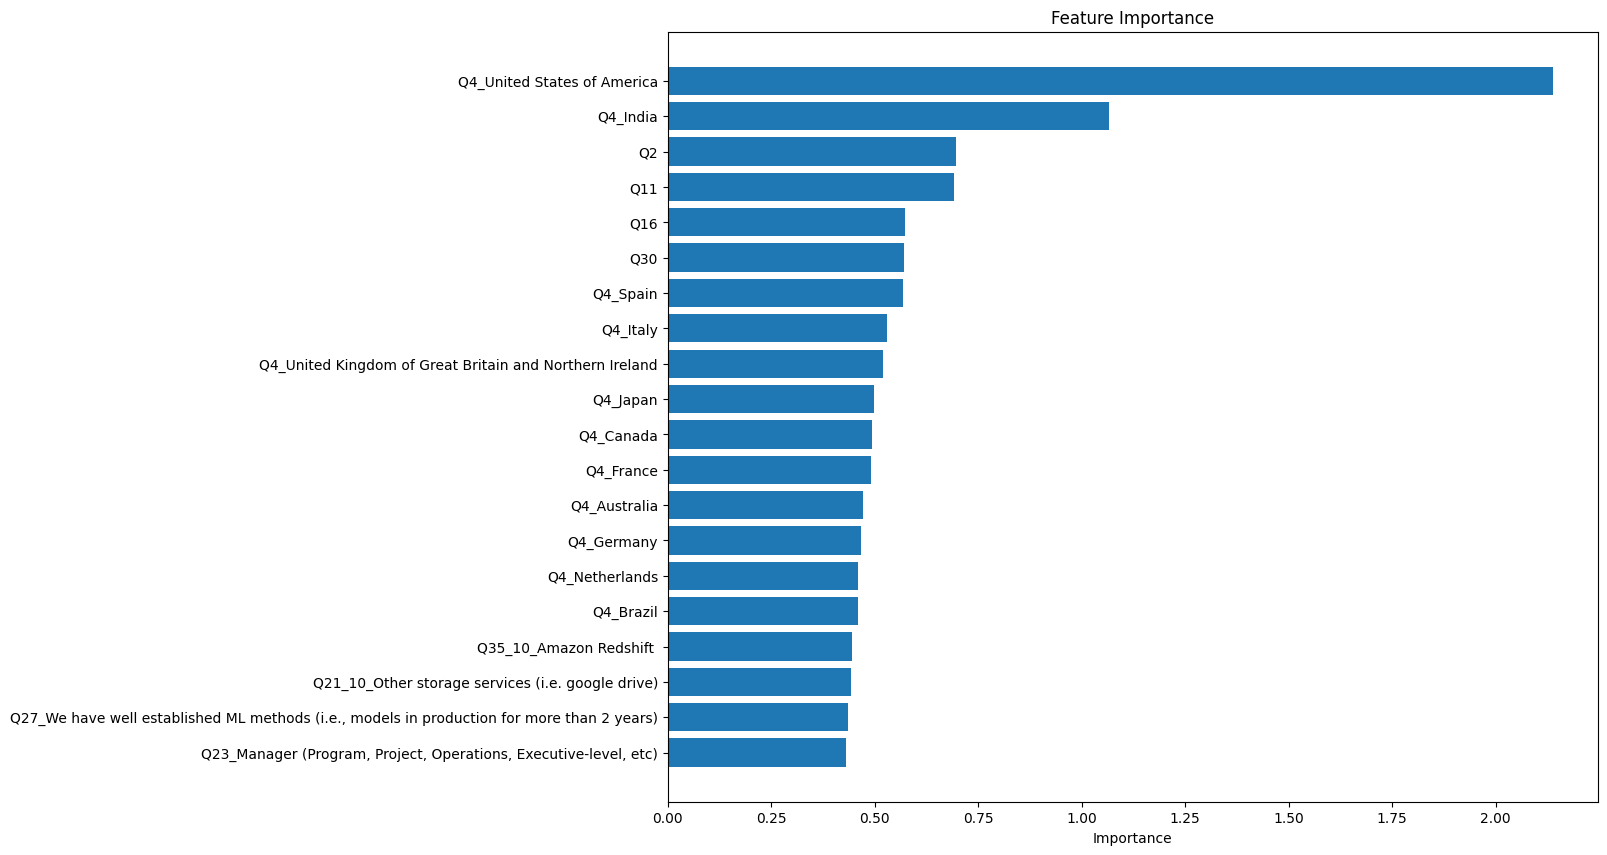

In [22]:
# After training your model

# Make sure to convert the model to CPU if it's currently on GPU
model.to('cpu')

# Retrieve the weights from the model's linear layer
weights = model.linear.weight.data.numpy()

# Sum the absolute value of weights across all output classes (if multiclass classification)
importance = np.abs(weights).sum(axis=0)

# Get the selected features from the SelectKBest if you used it, otherwise use all features
# Since you used k=396, we assume all 396 encoded features were selected
selected_features = X.columns

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': importance})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20])  # Top 20 features
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()


## BEST


In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)

# Define the logistic regression model
class LogisticRegressionModel(nn.Module):
    def __init__(self, n_features, n_classes):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(n_features, n_classes)

    def forward(self, x):
        return self.linear(x)

# Define hyperparameters for grid search
weight_decays = [0.0001, 0.001, 0.01, 0.1, 1]
n_epochs = 50
batch_size = 64

# Set up K-Fold cross-validation
k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=True)

# Prepare to collect the fold results
grid_search_results = {}

# Start the cross-validation and grid search
for fold, (train_ids, val_ids) in enumerate(kfold.split(X_train_tensor)):
    print(f'Starting fold {fold+1}')

    # Split the data for this fold
    X_train_fold = X_train_tensor[train_ids]
    y_train_fold = y_train_tensor[train_ids]
    X_val_fold = X_train_tensor[val_ids]
    y_val_fold = y_train_tensor[val_ids]
    
    # Create DataLoaders for the current fold
    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    val_dataset = TensorDataset(X_val_fold, y_val_fold)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    for weight_decay in weight_decays:
        # Initialize the model for the current fold and weight decay
        model = LogisticRegressionModel(X_train_fold.shape[1], torch.max(y_train_tensor).item() + 1).to(device)
        optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=weight_decay)
        criterion = nn.CrossEntropyLoss()

        # Train the model
        for epoch in range(n_epochs):
            model.train()
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                loss.backward()
                optimizer.step()

        # Evaluate the model on the validation set
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                _, predicted = torch.max(y_pred.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()
        
        # Calculate validation accuracy
        accuracy = correct / total
        print(f'Fold {fold+1}, Weight Decay {weight_decay}, Validation Accuracy: {accuracy}')

        # Update grid search results
        grid_search_results[(fold+1, weight_decay)] = accuracy

# Find the best weight decay value based on validation accuracy
best_weight_decay = max(grid_search_results, key=grid_search_results.get)[1]
print(f'Best weight decay: {best_weight_decay}')

# Calculate the average accuracy over all folds for the best weight decay
avg_accuracy = np.mean([val for key, val in grid_search_results.items() if key[1] == best_weight_decay])
print(f'Average validation accuracy for the best weight decay {best_weight_decay}: {avg_accuracy}')


Using GPU: NVIDIA GeForce RTX 3060
Starting fold 1
Fold 1, Weight Decay 0.0001, Validation Accuracy: 0.3717357910906298


KeyboardInterrupt: 